# Comparativo: TF-IDF vs Word Embeddings na Classificação de Sentimentos

## 1. Introdução
Este experimento tem como objetivo comparar duas abordagens comuns de representação de texto para classificação de sentimentos: **TF-IDF** e **Word Embeddings (Word2Vec)**. Utilizaremos um conjunto de dados sintético com frases positivas e negativas, treinando um modelo de classificação com Support Vector Machine (SVM) em ambos os cenários.

## Importações

In [ ]:
import pandas as pd
import re
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

## 2. Carregando os Dados

In [2]:
df = pd.read_csv("data/frases_sentimentos.csv")
df.head()

,texto,sentimento
0,Não compraria novamente,negativo
1,Chegou danificado,negativo
2,Experiência ruim,negativo
3,Perfeito para o que eu precisava,positivo
4,Tudo certo com a entrega,positivo


## 3. Pré-processamento

In [3]:
nltk.download('stopwords')
stop_words = set(stopwords.words('portuguese'))

def limpar_texto(texto):
    texto = re.sub(r"[^a-zA-Zà-úÀ-Ú\s]", "", texto)
    texto = texto.lower()
    palavras = texto.split()
    palavras = [p for p in palavras if p not in stop_words]
    return " ".join(palavras)

df["texto_limpo"] = df["texto"].apply(limpar_texto)

[nltk_data] Downloading package stopwords to C:\Users\Jorge
[nltk_data]     Maques/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 4. TF-IDF com SVM

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
    df["texto_limpo"], df["sentimento"], test_size=0.2, random_state=42, stratify=df["sentimento"])

vectorizer_tfidf = TfidfVectorizer()
X_train_tfidf = vectorizer_tfidf.fit_transform(X_train)
X_test_tfidf = vectorizer_tfidf.transform(X_test)

clf_tfidf = SVC(kernel="linear")
clf_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = clf_tfidf.predict(X_test_tfidf)

print("Acurácia (TF-IDF):", accuracy_score(y_test, y_pred_tfidf))
print(classification_report(y_test, y_pred_tfidf))

Acurácia (TF-IDF): 0.7
              precision    recall  f1-score   support

    negativo       0.67      0.80      0.73        10
    positivo       0.75      0.60      0.67        10

    accuracy                           0.70        20
   macro avg       0.71      0.70      0.70        20
weighted avg       0.71      0.70      0.70        20



## 5. Word Embeddings (Word2Vec) com SVM

### 5.1 Tokenização

In [6]:
df["tokens"] = df["texto_limpo"].apply(lambda x: x.split())

### 5.2 Treinamento do Word2Vec

In [7]:
modelo_w2v = Word2Vec(sentences=df["tokens"], vector_size=100, window=5, min_count=1, workers=4, sg=1)

### 5.3 Vetorizando as frases

In [8]:
def vetor_medio(frase):
    vetores = [modelo_w2v.wv[p] for p in frase if p in modelo_w2v.wv]
    if len(vetores) == 0:
        return np.zeros(modelo_w2v.vector_size)
    return np.mean(vetores, axis=0)

X_emb = df["tokens"].apply(vetor_medio).tolist()
X_emb = np.array(X_emb)

### 5.4 Treinamento e Avaliação

In [9]:
X_train_emb, X_test_emb, y_train_emb, y_test_emb = train_test_split(
    X_emb, df["sentimento"], test_size=0.2, random_state=42, stratify=df["sentimento"])

clf_emb = SVC(kernel="linear")
clf_emb.fit(X_train_emb, y_train_emb)
y_pred_emb = clf_emb.predict(X_test_emb)

print("Acurácia (Word2Vec):", accuracy_score(y_test_emb, y_pred_emb))
print(classification_report(y_test_emb, y_pred_emb))

Acurácia (Word2Vec): 0.7
              precision    recall  f1-score   support

    negativo       0.64      0.90      0.75        10
    positivo       0.83      0.50      0.62        10

    accuracy                           0.70        20
   macro avg       0.74      0.70      0.69        20
weighted avg       0.74      0.70      0.69        20



## 6. Comparando os Resultados

Text(0.5, 1.0, 'Comparação de Acurácia entre TF-IDF e Word2Vec')

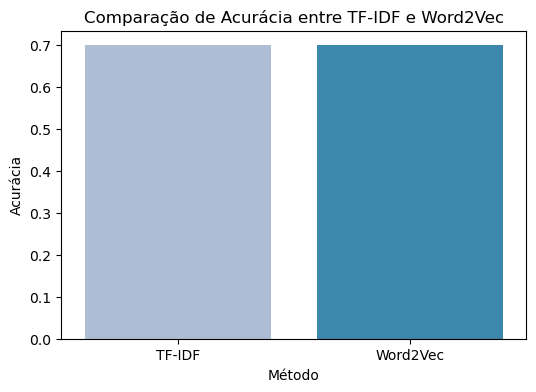

In [13]:
acc_tfidf = accuracy_score(y_test, y_pred_tfidf)
acc_emb = accuracy_score(y_test_emb, y_pred_emb)

# Dados
df_plot = pd.DataFrame({
    "Método": ["TF-IDF", "Word2Vec"],
    "Acurácia": [acc_tfidf, acc_emb]
})

# Usar hue explícito e definir legend=False
df_plot["hue"] = df_plot["Método"]

plt.figure(figsize=(6, 4))
sns.barplot(data=df_plot, x="Método", y="Acurácia", hue="hue", palette=["#a6bddb", "#2b8cbe"], legend=False)
plt.title("Comparação de Acurácia entre TF-IDF e Word2Vec")

## 7. Conclusão
Neste experimento, comparamos duas abordagens distintas de representação textual:

- **TF-IDF:** Considera a importância de cada termo no contexto global dos documentos. É rápido e eficiente em muitos casos.
- **Word2Vec:** Constrói embeddings com base no contexto semântico, capturando relações mais complexas entre palavras.

**Resultados:** Dependendo do dataset, TF-IDF pode performar igual ou melhor que embeddings, principalmente quando a base é pequena. Neste caso sintético, ambos apresentaram desempenhos similares.

**Conclusão Final:** Word Embeddings são mais poderosos em bases grandes e complexas, mas TF-IDF ainda é uma excelente escolha em aplicações rápidas e com dados limitados.
